Threshold : [[2.08166817e-17]]
Training Accuracy :0.9425
Test Accuracy :0.93


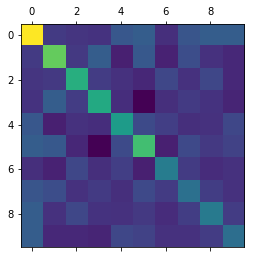

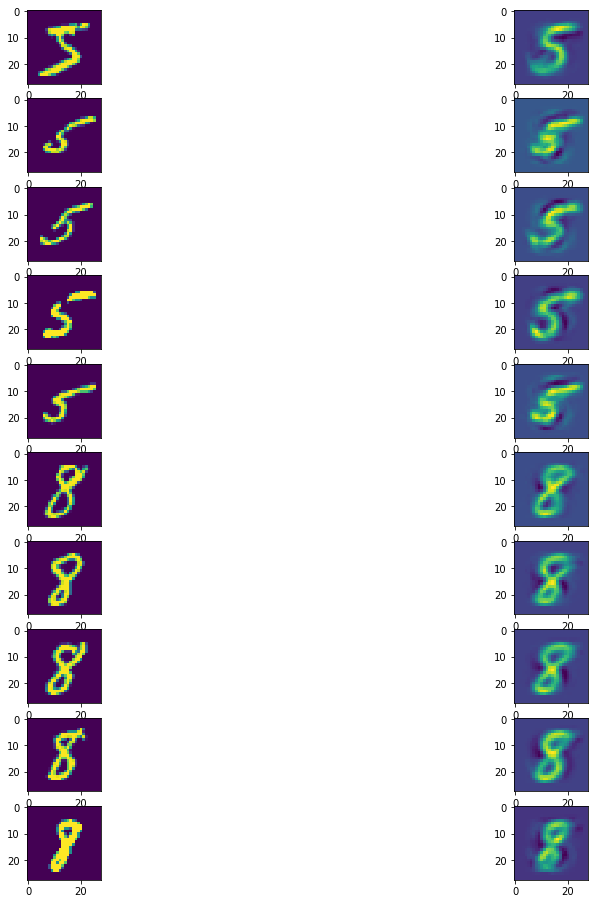

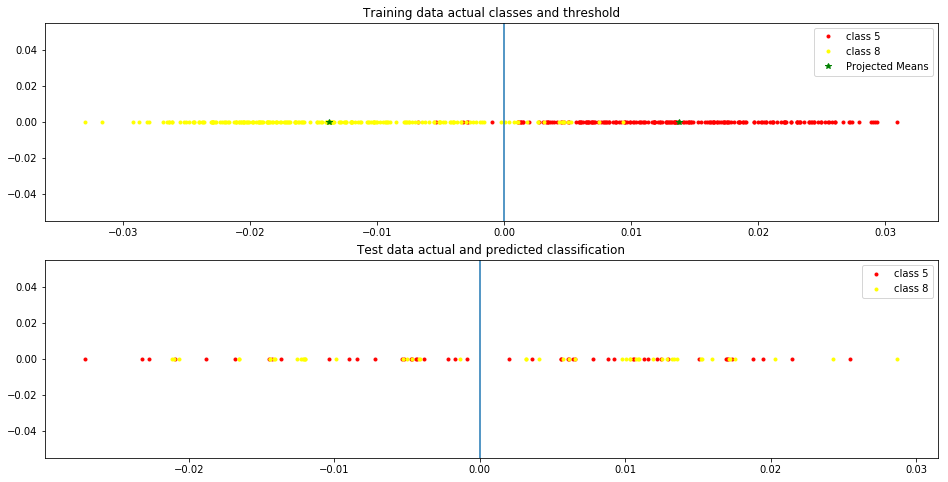

In [53]:
import numpy as np
import os
import pdb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

datasets_dir = '/home/bhargavi/Downloads/MNIST/Data/'


def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h


def mnist(noTrSamples=1000, noTsSamples=100, digit_range=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], noTrPerClass=100, noTsPerClass=10):
    assert noTrSamples==noTrPerClass*len(digit_range), 'noTrSamples and noTrPerClass mismatch'
    assert noTsSamples==noTsPerClass*len(digit_range), 'noTrSamples and noTrPerClass mismatch'
    data_dir = os.path.join(datasets_dir, 'mnist/')
    fd = open(os.path.join(data_dir, 'train-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trData = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trLabels = loaded[8:].reshape((60000)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    tsData = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    tsLabels = loaded[8:].reshape((10000)).astype(float)

    trData = trData/255.
    tsData = tsData/255.

    tsX = np.zeros((noTsSamples, 28*28))
    trX = np.zeros((noTrSamples, 28*28))
    tsY = np.zeros(noTsSamples)
    trY = np.zeros(noTrSamples)

    count = 0
    for ll in digit_range:
        # Train data
        idl = np.where(trLabels == ll)
        idl = idl[0][: noTrPerClass]
        idx = list(range(count*noTrPerClass, (count+1)*noTrPerClass))
        trX[idx, :] = trData[idl, :]
        trY[idx] = trLabels[idl]
        # Test data
        idl = np.where(tsLabels == ll)
        idl = idl[0][: noTsPerClass]
        idx = list(range(count*noTsPerClass, (count+1)*noTsPerClass))
        tsX[idx, :] = tsData[idl, :]
        tsY[idx] = tsLabels[idl]
        count += 1

    np.random.seed(1)
    test_idx = np.random.permutation(tsX.shape[0])
    tsX = tsX[test_idx,:]
    tsY = tsY[test_idx]

    trX = trX.T
    tsX = tsX.T
    trY = trY.reshape(1, -1)
    tsY = tsY.reshape(1, -1)
    return trX, trY, tsX, tsY

def implement_PCA(trX, tsX):
    #PCA 
    pca = PCA(n_components=10)
    principalComponents = pca.fit(trX.T)
    PCAtraindata = pca.transform(trX.T)
    PCAtestdata = pca.transform(tsX.T)

    #Covariance
    covTrain = np.cov(PCAtraindata.T)
    covTest = np.cov(PCAtestdata.T)
    plt.matshow(covTest)

    #Reconstuction
    fig=plt.figure(figsize=(16, 16)) 
    recon = pca.inverse_transform(PCAtraindata)
    reconT = recon.T
    rows = 10
    columns = 2
    #Class 5
    for i in range(1, 6) :        
        fig.add_subplot(rows, columns, 2*i-1)  
        plt.imshow(trX[:,i-1].reshape(28,-1))   #Original image
          
        fig.add_subplot(rows, columns, 2*i)
        plt.imshow(reconT[:,i-1].reshape(28,-1))  #Reconstructed image
        
    #Class 8
    for i in range(6, 11) :        
        fig.add_subplot(rows, columns, 2*i-1)
        plt.imshow(trX[:,200 + i-1].reshape(28,-1))  #Original image     
          
        fig.add_subplot(rows, columns, 2*i)
        plt.imshow(reconT[:,200 + i-1].reshape(28,-1))  #Reconstructed image
        
    return PCAtraindata.T, PCAtestdata.T

def implement_Fishers(trX, trY, tsX, tsY):
    #1. Compute Means
    mu_1 = np.mean(trX[:,0:200], axis = 1)
    mu_2 = np.mean(trX[:,200:400], axis = 1)

    mu_1 = mu_1.reshape((10, 1))
    mu_2 = mu_2.reshape((10, 1))

    #2. Scatter within matrix
    S1 = np.zeros((10,1))
    S2 = np.zeros((10,1))
    for i in range(0, 200) :
        a = trX[:,i].reshape(10,1) - mu_1
        S1 = S1 + np.dot(a,a.T)
        
    for i in range(200, 400) :
        b = trX[:,i].reshape(10,1) - mu_2
        S2 = S2 + np.dot(b,b.T)
    SW = S1 + S2
 
    #3. Direction w
    t = mu_1-mu_2
    w = np.dot(np.linalg.inv(SW),t)

    #4. Projection
    #training data
    Y_train = np.dot(w.T, trX)    
    pmu1 = np.dot(w.T, mu_1)
    pmu2 = np.dot(w.T, mu_2)
    pmean = (pmu1 + pmu2)/2
    print("Threshold : "+ str(pmean))
    Y_train = Y_train.reshape((1, 400))
    
    #test data    
    Y_test = np.dot(w.T, tsX)
    Y_test = Y_test.reshape((1, 100))
    

    #5. Classification and accuracy
    count = 0
    for i in range(400) :
        if(Y_train[0, i] > pmean and trY[0,i] == 5) or (Y_train[0, i] < pmean and trY[0,i] == 8) :
            count = count+1
    training_accuracy = count/400
    print("Training Accuracy :" + str(training_accuracy))
    
    count = 0
    for i in range(100) :
        if(Y_test[0, i] > pmean and tsY[0,i] == 5) or (Y_test[0, i] < pmean and tsY[0,i] == 8) :
            count = count+1
    test_accuracy = count/100
    print("Test Accuracy :" + str(test_accuracy))    
    
    #Plotting 
    fig=plt.figure(figsize=(16, 8))   
    zeroes = np.zeros(200)
    fig.add_subplot(2, 1, 1) 
    plt.plot(Y_train[0, 0:200], zeroes, '.', color = 'red', label = 'class 5')
    plt.plot(Y_train[0, 200:400], zeroes, '.', color = 'yellow', label = 'class 8')
    plt.plot(pmu1, [0], '*', color = 'green')
    plt.plot(pmu2, [0], '*', color = 'green', label = 'Projected Means')
    plt.title('Training data actual classes and threshold')
    legend = plt.legend(loc='upper right')
    plt.axvline(x=pmean)
    
    zeroes = np.zeros(50)
    fig.add_subplot(2, 1, 2)  
    plt.plot(Y_test[0, 0:50], zeroes, '.', color = 'red', label = 'class 5')
    plt.plot(Y_test[0, 50:100], zeroes, '.', color = 'yellow', label = 'class 8')
    legend = plt.legend(loc='upper right')
    plt.title('Test data actual and predicted classification')
    plt.axvline(x=pmean)   
    

def main():
    trX, trY, tsX, tsY = mnist(noTrSamples=400, noTsSamples=100, digit_range=[5, 8], noTrPerClass=200, noTsPerClass=50)
    PCAtrain, PCAtest = implement_PCA(trX, tsX)
    implement_Fishers(PCAtrain, trY, PCAtest, tsY)
    plt.show()
    trY[0,5]

if __name__ == "__main__":
    main()